In [1]:
import pandas as pd
import tensorflow 
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import nltk
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
import spacy
import re
import sklearn
from sklearn.model_selection import train_test_split
import tqdm
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))
from gensim.models import Word2Vec
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\faysa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


ImportError: cannot import name 'triu' from 'scipy.linalg' (C:\Users\faysa\anaconda3\envs\NewMlEnv\lib\site-packages\scipy\linalg\__init__.py)

In [2]:
columns  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "latin-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=columns).sample(frac=1)

dataset = dataset[['sentiment','text']]

dataset['sentiment'] = dataset['sentiment'].replace(4,1)



In [3]:
dataset[dataset['sentiment']==0]

,sentiment,text
592823,0,@tweeterisatrend what's wrong?
313746,0,@winterchick12 idk..i can't follow more than 2...
47693,0,Random ER episodes on TV in Bangkok. Comparing...
113955,0,Driving back down to wales later
157483,0,Don't feel very well Going to have a brief na...
...,...,...
656784,0,i just realised that my high school education ...
562642,0,Appliying for a crappy job I don't want
480664,0,"I love Chinese, but Chinese doesn't love me"
82753,0,i turrned my comp off aim? leundeadhorreur


In [4]:
dataset['sentiment'].unique()

array([1, 0])

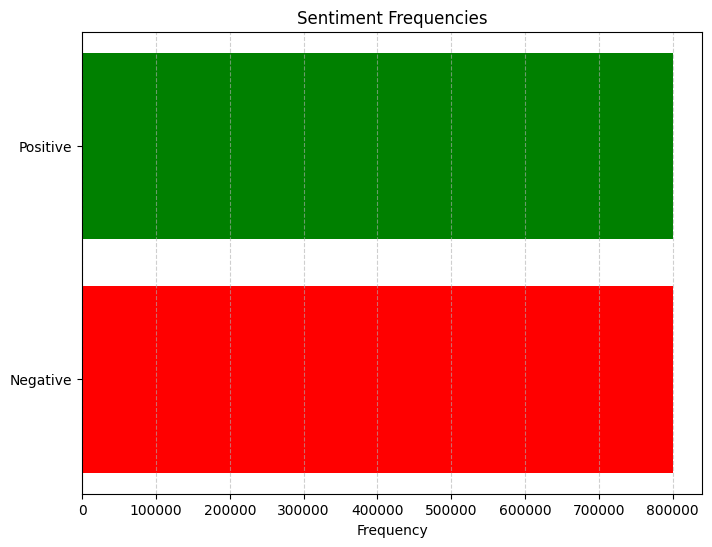

In [5]:
plt.rcParams['font.family'] = 'DejaVu Sans'
sentiment_counts = dataset['sentiment'].value_counts()
sentiment_labels = {'Negative': 0, 'Positive': 1}
plt.figure(figsize=(8, 6))
plt.barh(list(sentiment_labels.keys()), list(sentiment_counts.values), color=['red', 'green', 'blue'])
plt.xlabel("Frequency")
plt.yticks(list(sentiment_labels.values()), list(sentiment_labels.keys()))
plt.title("Sentiment Frequencies")
plt.grid(axis='x', linestyle='--', alpha=0.6)

plt.show()

In [6]:
dataset.isna().sum()

sentiment    0
text         0
dtype: int64

In [7]:
x,y=dataset['text'],dataset['sentiment']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,shuffle=True)

In [8]:
len(x_train),len(x_test)

(1280000, 320000)

In [9]:
def process_text(document,stopwords=STOPWORDS):
    nlp = spacy.load("en_core_web_sm")
    document = re.sub(r'\s+', ' ', document, flags=re.I) 
    document = re.sub(r'\W', ' ', str(document))
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document) 
    document = document.lower() 
    doc_spacy=nlp(document)
    lemma_txt = ["".join(token.lemma_) for token in tqdm.tqdm(doc_spacy)]
    lemma_no_stop_txt = [word for word in lemma_txt if word not in stopwords]
    lemma_no_stop_txt = [word for word in lemma_no_stop_txt if len(word) > 3]
    clean_txt = ' '.join(lemma_no_stop_txt)
    return clean_txt

x_train_preprocessed= x_train

In [10]:
x_train_preprocessed

1085114    Forgot my phone today &amp; I think it added t...
1507132    Who needs enemies when you have friends like m...
883502         Sent email to Tony Blackburn blaming him Lol 
1499876    @jiletta I drink at least a few a day!!  So I ...
596362     I should go to bed, but I'm not especially tir...
                                 ...                        
1542751    Emailing my grad school adviser, I like the so...
1328524           Im  happy today ) http://plurk.com/p/y4gae
311813     tore some ligerments in my foot and ankle last...
154732     dropped Anders off at train station this morni...
250735     I dont want to do exams  damn.. has anyone got...
Name: text, Length: 1280000, dtype: object

In [11]:
x_train_preprocessed.to_csv('/kaggle/working/x_train_preprocessed.csv')


In [12]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(x_train_preprocessed)  # Ensure consistent preprocessing
X_train_sequences = tokenizer.texts_to_sequences(x_train_preprocessed)
X_test_sequences = tokenizer.texts_to_sequences(x_test)
max_sequence_length = max([len(seq) for seq in X_train_sequences])
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)
pd.DataFrame({'words':tokenizer.sequences_to_texts(list(X_train_sequences)),'sequances':X_train_sequences})

,words,sequances
0,forgot my phone today amp i think it added to ...,"[479, 6, 223, 41, 66, 2, 81, 10, 1511, 3, 4, 1..."
1,who needs enemies when you have friends like mine,"[176, 518, 12037, 86, 8, 17, 205, 36, 416]"
2,sent email to tony blackburn blaming him lol,"[778, 652, 3, 2395, 33070, 10577, 154, 50]"
3,jiletta i drink at least a few a day so i make...,"[196011, 2, 654, 24, 355, 5, 315, 5, 31, 16, 2..."
4,i should go to bed but i'm not especially tire...,"[2, 142, 38, 3, 144, 19, 20, 25, 871, 182, 106..."
...,...,...
1279995,emailing my grad school adviser i like the sou...,"[8988, 6, 1567, 151, 22431, 2, 36, 4, 700, 13,..."
1279996,im happy today http plurk com p y4gae,"[59, 120, 41, 40, 437, 57, 232, 594922]"
1279997,tore some ligerments in my foot and ankle last...,"[8406, 71, 594923, 11, 6, 1263, 7, 2081, 5224,..."
1279998,dropped anders off at train station this morni...,"[1286, 29950, 90, 24, 601, 1545, 27, 98, 20, 5..."


In [13]:
y_train

1085114    1
1507132    1
883502     1
1499876    1
596362     0
          ..
1542751    1
1328524    1
311813     0
154732     0
250735     0
Name: sentiment, Length: 1280000, dtype: int64

In [14]:
len(tokenizer.word_index)

594923

In [18]:
model = Sequential([
Embedding(len(tokenizer.word_index)+1, 64),
Conv1D(64, 3, activation='relu'),
MaxPooling1D(2,2),
Dropout(0.2),
Conv1D(32,3, activation='relu'),
MaxPooling1D(2,2),
Flatten(),
Dense(8, activation='relu'),
Dense(1, activation='sigmoid'),]
)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
Early_Stopping=tensorflow.keras.callbacks.EarlyStopping(patience=3,verbose=1)
history=model.fit(X_train_padded,y_train, epochs=20,batch_size=128,callbacks=[Early_Stopping])

Epoch 1/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 90s 9ms/step - accuracy: 0.7847 - loss: 0.4491
Epoch 2/20
    7/10000 ━━━━━━━━━━━━━━━━━━━━ 1:26 9ms/step - accuracy: 0.8645 - loss: 0.3093   

/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


10000/10000 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.8715 - loss: 0.3021
Epoch 3/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.9110 - loss: 0.2192
Epoch 4/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.9310 - loss: 0.1725
Epoch 5/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.9421 - loss: 0.1451
Epoch 6/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - accuracy: 0.9502 - loss: 0.1251
Epoch 7/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.9557 - loss: 0.1111
Epoch 8/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.9600 - loss: 0.1006
Epoch 9/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 86s 9ms/step - accuracy: 0.9633 - loss: 0.0929
Epoch 10/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 86s 9ms/step - accuracy: 0.9656 - loss: 0.0867
Epoch 11/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.9680 - loss: 0.0810
Epoch 12/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 85s 9ms/step - accuracy: 0.9694 - loss: 0.0775
Epoch 1

In [20]:
test_history=model.evaluate(X_test_padded,y_test)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.7822 - loss: 0.9012


In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (128, 118, 64)         │    38,075,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (128, 116, 64)         │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (128, 58, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (128, 58, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (128, 56, 32)          │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (128, 28, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (128, 896)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (128, 8)               │         7,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (128, 1)               │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,302,549 (436.03 MB)

 Trainable params: 38,100,849 (145.34 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 76,201,700 (290.69 MB)

In [22]:
X_train_padded

array([[    0,     0,     0, ...,    22,     4,   347],
       [    0,     0,     0, ...,   205,    36,   416],
       [    0,     0,     0, ..., 10577,   154,    50],
       ...,
       [    0,     0,     0, ...,  5224,    16,   623],
       [    0,     0,     0, ...,  1450,   352,   178],
       [    0,     0,     0, ...,     3,   337,    15]], dtype=int32)

In [23]:
def predict_sentiment(input_text, model, tokenizer,max_sequence_length=max_sequence_length):
    classes = ['Negative', 'Positive']
    x_test_sequences = tokenizer.texts_to_sequences(input_text)
    X_test_padded = pad_sequences(x_test_sequences, maxlen=max_sequence_length, truncating='pre')
    probabilities = model.predict(X_test_padded)
    predictions = classes[int(np.round([i for i in probabilities]))]
    return predictions



In [34]:
 predict_sentiment(['ifeel that i didnt drink any coffe from 10 months'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


'Negative'

In [1]:
 predict_sentiment(['ifeel that drink  coffe ,iam happy and have big contractions '], model, tokenizer)

NameError: name 'predict_sentiment' is not defined

In [36]:
 predict_sentiment(['You’re doing great!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


'Positive'

In [37]:
 predict_sentiment(['negative!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


'Negative'

In [38]:
 predict_sentiment(['You’re doing bad!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


'Negative'

In [39]:
 predict_sentiment(['I will kill my self!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


'Negative'

In [40]:
 predict_sentiment(['I will burn my self!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


'Negative'

In [41]:
 predict_sentiment(['I am happy its my birthday!'], model, tokenizer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


'Positive'

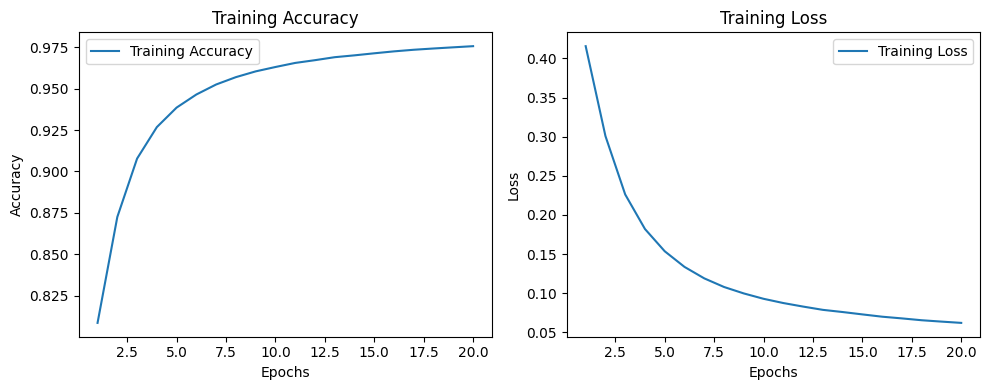

In [32]:
import matplotlib.pyplot as plt

def plot_training_history(history):

    train_accuracy = history.history['accuracy']
    train_loss = history.history['loss']

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)